In [1]:
# %load '../input/yolo-configs/libraries.py'
import tensorflow as tf
from IPython.display import clear_output
import itertools, re, os, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from pylab import rcParams
from tensorflow.keras.models import Sequential, save_model

from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, Input, concatenate, Reshape, Conv2DTranspose, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras import layers, Input, Model, models, regularizers, optimizers

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping



from sklearn.utils import class_weight

import tensorflow_addons as tfa

from tensorflow.keras.layers import Conv1D, Convolution1D, MaxPooling1D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
import math

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.image as mpimg
import plotly.express as px

from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

color_box={}
color_box[0]=['lime','y']
color_box[1]=['deepskyblue','orangered']

use=[*range(0, 2624, 1)]


batch_size=10
image_width=800
image_height=800
sizei=2
each_sizei=8
total_sizei=25
channels_size=3
global extreme
global individual_width
global individual_height
individual_width=8
individual_height=8


d={}
d[0]='car'
d[1]='pedestrian'
    
global no_of_anchors,no_of_classes,threshold, thresh_iou,max_box
no_of_anchors=each_sizei
no_of_classes=sizei
threshold=0.2
threshold_iou=0.1
max_box=500

from tensorflow.keras.models import load_model
import cv2
from PIL import Image

from tensorflow.keras.models import model_from_json
from PIL import Image as im

2021-12-02 04:10:41.977886: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-02 04:10:41.978012: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# %load '../input/yolo-configs/helper.py'
def yolo_filter_boxes(boxes, box_confidence, threshold):
    filtering_mask = box_confidence>=threshold
    filtering_mask=tf.reshape(filtering_mask,(1,individual_width,individual_height,each_sizei))
    boxes = tf.boolean_mask(boxes,filtering_mask)
    box_confidence=tf.reshape(tf.boolean_mask(box_confidence,filtering_mask),(-1))
    return box_confidence, boxes


def iou(box1, box2):
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    xi1 = max(box1_x1,box2_x1)
    yi1 = max(box1_y1,box2_y1)
    xi2 = min(box1_x2,box2_x2)
    yi2 = min(box1_y2,box2_y2)
    inter_width = max(xi2-xi1,0)
    inter_height = max(yi2-yi1,0)
    inter_area = inter_width*inter_height
    box1_area = abs(box1_x2-box1_x1)*abs(box1_y2-box1_y1)
    box2_area = abs(box2_x2-box2_x1)*abs(box2_y2-box2_y1)
    union_area = box1_area+box2_area-inter_area
    iou = inter_area/union_area
    return iou

def yolo_non_max_suppression(scores, boxes, max_boxes, iou_threshold):
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold=iou_threshold,name=None)
    scores = tf.gather(scores, nms_indices, validate_indices=None, axis=None, batch_dims=0, name=None)
    boxes = tf.gather(boxes, nms_indices, validate_indices=None, axis=None, batch_dims=0, name=None)
    return scores, boxes

def yolo_boxes_to_corners(box_xy, box_wh):
    box_mins = box_xy - (box_wh/2.)
    box_maxes = box_xy + (box_wh/2. )
    return tf.keras.backend.concatenate([
        box_mins[:,:,:,:,0:1],  # y_min
        box_mins[:,:,:,:,1:2],  # x_min
        box_maxes[:,:,:,:,0:1],  # y_max
        box_maxes[:,:,:,:,1:2]  # x_max
    ])

def yolo_head(x):
    boxes_=x[:,:,:,:,1:5]
    box_wh=x[:,:,:,:,3:5]
    box_xy=x[:,:,:,:,1:3]
    confidence_=x[:,:,:,:,:1]
    boxes_ = yolo_boxes_to_corners(box_xy,box_wh)
    scores,boxes=yolo_filter_boxes(boxes_,confidence_,threshold)
    scores,boxes=yolo_non_max_suppression(scores,boxes,max_box,threshold_iou)
    return scores, boxes


def predict(image_file,dola):
    import matplotlib.pyplot as plt
    from tensorflow.keras.preprocessing import image
    img = image.load_img(image_file, target_size=(image_width, image_height))
    x = image.img_to_array(img)
    if(len(dola)>1):
        x=dola
    x = np.expand_dims(x, axis=0)
    a=modeli.predict(x)
    a=tf.reshape(a,(1,individual_width,individual_height,41))
    a=a[:,:,:,1:]
    a=tf.reshape(a,(1,individual_width,individual_height,each_sizei,5))
    
    out_scores, out_boxes=yolo_head(a)

    return out_scores, out_boxes


def verify(encoding):
    maxi=10000
    human = 'Ankit'
    for i in encodings:
        dist = np.linalg.norm(encoding - encodings[i])
        if dist < maxi:
            maxi=dist
            human=i
    return maxi,human


def img_to_encoding(img, model):
#     img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [3]:
path='../input/hurry-up/best_model.h5'
modeli = load_model(path, compile=False)

2021-12-02 04:10:50.848805: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-02 04:10:50.851497: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-02 04:10:50.851528: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-02 04:10:50.851557: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (aecda41191d0): /proc/driver/nvidia/version does not exist
2021-12-02 04:10:50.851808: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [4]:
os.mkdir('gola')

In [5]:
json_file = open('../input/facenet/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('../input/facenet/model.h5')

# start

In [6]:
encodings={}
def prepare_encodings(path):
    for i in os.listdir(path):
        if i.endswith(".jpg"):
            name=os.path.splitext(i)[0]
            image_file=path+'/'+i
            scores,boxe=predict(image_file,[1])
            boxe=boxe.numpy()[0]*800
            boxe=boxe.astype('int32')
            image = Image.open(image_file)
            image = image.resize((800,800))
            image = np.asarray(image)
            crop = image[boxe[1]:boxe[3], boxe[0]:boxe[2]]
            plt.imshow(crop)
            crop=im.fromarray(crop)
            crop=crop.resize((160,160))
            encodings[name] = img_to_encoding(crop,model)

2021-12-02 04:11:07.765038: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-02 04:11:07.778042: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


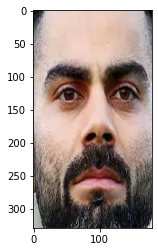

In [7]:
prepare_encodings('../input/facess')

In [8]:
import cv2
from matplotlib.patches import Rectangle
legend_properties = {'weight':'bold'}
vidcap = cv2.VideoCapture('../input/facess/virushka.mp4')
image_file = '../input/facess/virat.jpg'
success,image = vidcap.read()
count = 0
while success:
    image = cv2.resize(image, (800, 800))
    fig, ax = plt.subplots()
    ax.imshow(image)
    scores,boxe=predict(image_file,image)
    boxe=boxe.numpy()*800
    scores=scores.numpy()
    boxe=boxe.astype('int32')
    if(len(scores)>0):
        for j in range(len(scores)):
            boe=boxe[j]
            crop = image[boe[1]:boe[3], boe[0]:boe[2]]
            crop=im.fromarray(crop)
            crop=crop.resize((160,160))
            encoding = img_to_encoding(crop,model)
            disti,namei = verify(encoding)
            if(namei!='Ankit'):
                w=boe[2]-boe[0]
                h=boe[3]-boe[1]
                rect = Rectangle((boe[0], boe[1]), w, h, linewidth=1, edgecolor='g', facecolor='none',lw=1.3)
                ax.text(boe[0], boe[1], namei+'__'+str(scores[j]), fontsize=9, color='y')
                ax.legend(prop=legend_properties)
                ax.add_patch(rect)
    fig.savefig('./gola/virushka_%d.png' %count, dpi = 100)
    plt.close(fig)
    success,image = vidcap.read()
    count += 1

image_file='../input/facess/IMG_20211026_111517.jpg'
scores,boxe=predict(image_file)
boxe=boxe.numpy()[0]*800
boxe=boxe.astype('int32')
image = Image.open(image_file)
image = image.resize((800,800))
image = np.asarray(image)
crop = image[boxe[1]:boxe[3], boxe[0]:boxe[2]]
plt.imshow(crop)
crop=im.fromarray(crop)
crop=crop.resize((160,160))
a,b=verify(encodings['ankit'],img_to_encoding(crop,model))

print(a,b)

In [10]:
os.mkdir('tola')

In [11]:
def generate_video():
    image_folder = './gola' # make sure to use your folder
    video_name = 'mygeneratedvideo.avi'
    os.chdir("./tola")
      
    images = [img for img in os.listdir(image_folder)
              if img.endswith(".jpg") or
                 img.endswith(".jpeg") or
                 img.endswith("png")]
     
    # Array images should only consider
    # the image files ignoring others if any
  
    frame = cv2.imread(os.path.join(image_folder, images[0]))
  
    # setting the frame width, height width
    # the width, height of first image
    height, width, layers = frame.shape  
  
    video = cv2.VideoWriter(video_name, 0, 1, (width, height)) 
  
    # Appending the images to the video one by one
    for image in images: 
        video.write(cv2.imread(os.path.join(image_folder, image))) 
      
    # Deallocating memories taken for window creation
    cv2.destroyAllWindows() 
    video.release()  # releasing the video generated
  
  
# Calling the generate_video function
generate_video()

FileNotFoundError: [Errno 2] No such file or directory: './gola'